In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [13]:
import astromet
print(astromet.__file__)
import numpy as np
import matplotlib.pyplot as plt

# an object wich holds all the necessary parameters to generate the astrometric track
params=astromet.params()

# center of mass parameters
params.ra=160     #[deg]
params.dec=-50    #[deg]
params.drac=0     #[mas]
params.ddec=0     #[mas]
params.pmrac=8    #[mas/yr]
params.pmdec=-2   #[mas/yr]
params.pllx=5     #[mas]

/Users/zephyr/Google Drive/astro/pythonModules/dev/astromet/astromet/__init__.py


In [3]:
# random times between 2014 and 2018 - a very rough approximation to Gaia eDR3
ts=2014 + 4*np.random.rand(100)

# optionally use the much simpler Kepler equation solver if numba causes errors
#astromet.use_backup=True

# finds the exact position in RAcos(Dec) and Dec [mas]
racs,decs=astromet.track(ts,params)

using backup Kepler equation solver


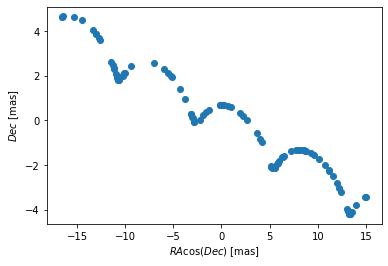

In [4]:
ax=plt.gca()
ax.scatter(racs,decs)
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/singleBody.png')
plt.show()

In [24]:
# binary parameters
# (for single stars leave these blank or set l=q)
params.period=2      #[yr]
params.a=2    #[AU]
params.e=0.8
params.q=0.5
params.l=0.1
# viewing angle
params.vphi=4.5   #[rad]
params.vtheta=1.5 #[rad]
params.vomega=5.6 #[rad]
# time of some periapse passage
params.tperi=2016 #[jyear]

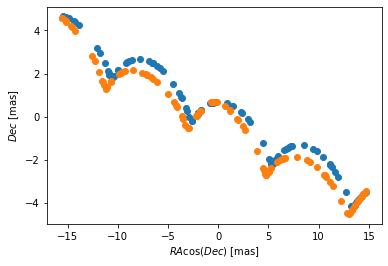

In [25]:
bracs,bdecs=astromet.track(ts,params)

ax=plt.gca()
ax.scatter(racs,decs)
ax.scatter(bracs,bdecs)
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBody.png')
plt.show()

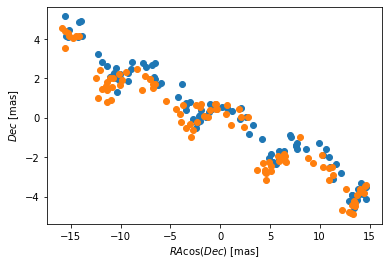

In [26]:
ast_error=0.3 # [mas]

obsracs=racs+ast_error*np.random.randn(ts.size)
obsdecs=decs+ast_error*np.random.randn(ts.size)

bobsracs=bracs+ast_error*np.random.randn(ts.size)
bobsdecs=bdecs+ast_error*np.random.randn(ts.size)

ax=plt.gca()
ax.scatter(obsracs,obsdecs)
ax.scatter(bobsracs,bobsdecs)
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBodyError.png')
plt.show()

In [8]:
results=astromet.simple_fit(ts,obsracs,obsdecs,ast_error,params.ra,params.dec)
print(results)

{'vis_periods': 75, 'n_obs': 100, 'drac': -0.007766240691667925, 'drac_error': 0.030486536049014072, 'ddec': 0.030751705185921713, 'ddec_error': 0.03030032442104083, 'drac_ddec_corr': -0.007114293117752358, 'parallax': 0.9218987445977341, 'parallax_error': 0.033478070113177126, 'drac_parallax_corr': -0.12418067255828391, 'ddec_parallax_corr': 0.057289858165434575, 'pmrac': 8.014754571895496, 'pmrac_error': 0.025939699801821654, 'drac_pmrac_corr': -0.015543309330120209, 'ddec_pmrac_corr': 0.0035760516817386397, 'parallax_pmrac_corr': 0.062420327022143444, 'pmdec': -2.037854552978243, 'pmdec_error': 0.02593136699188728, 'drac_pmdec_corr': -0.007085937382276317, 'ddec_pmdec_corr': -0.004573269695395258, 'parallax_pmdec_corr': 0.05706151558287421, 'pmrac_pmdec_corr': 0.0035617984630621426, 'UWE': 1.00832074745823, 'ra_ref': 160, 'dec_ref': -50}


In [9]:
bresults=astromet.simple_fit(ts,bobsracs,bobsdecs,ast_error,params.ra,params.dec)
print(bresults)

{'vis_periods': 75, 'n_obs': 100, 'drac': -0.5298475358724917, 'drac_error': 0.035035745440845804, 'ddec': -0.35228166872784805, 'ddec_error': 0.03482174726193473, 'drac_ddec_corr': -0.007114293117752359, 'parallax': 1.0304210685257433, 'parallax_error': 0.03847367705043007, 'drac_parallax_corr': -0.12418067255828391, 'ddec_parallax_corr': 0.057289858165434575, 'pmrac': 8.02828793986024, 'pmrac_error': 0.02981042902373203, 'drac_pmrac_corr': -0.01554330933012021, 'ddec_pmrac_corr': 0.0035760516817386397, 'parallax_pmrac_corr': 0.062420327022143444, 'pmdec': -2.059232108574975, 'pmdec_error': 0.029800852789580723, 'drac_pmdec_corr': -0.007085937382276318, 'ddec_pmdec_corr': -0.004573269695395259, 'parallax_pmdec_corr': 0.057061515582874214, 'pmrac_pmdec_corr': 0.0035617984630621417, 'UWE': 1.1587826499499079, 'ra_ref': 160, 'dec_ref': -50}


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


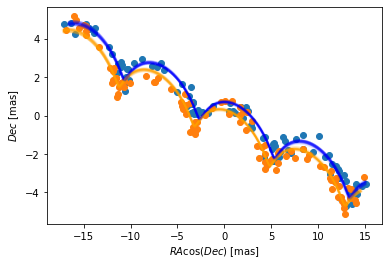

In [10]:
ax=plt.gca()
ax.scatter(obsracs,obsdecs)
ax.scatter(bobsracs,bobsdecs)

plotts=np.linspace(np.min(ts),np.max(ts),200)
fitparams=astromet.params()
bfitparams=astromet.params()
for i in range(32):
    fitparams.ra=160     #[deg]
    fitparams.dec=-50    #[deg]
    fitparams.drac=results['drac']+results['drac_error']*np.random.randn()     #[mas]
    fitparams.ddec=results['ddec']+results['ddec_error']*np.random.randn()     #[mas]
    fitparams.pmrac=results['pmrac']+results['pmrac_error']*np.random.randn()    #[mas/yr]
    fitparams.pmdec=results['pmdec']+results['pmdec_error']*np.random.randn()   #[mas/yr]
    fitparams.pllx=results['parallax']+results['parallax_error']*np.random.randn()     #[mas]
    
    fitracs,fitdecs=astromet.track(plotts,fitparams)
    ax.plot(fitracs,fitdecs,c='blue',alpha=0.1)
    
    bfitparams.ra=160     #[deg]
    bfitparams.dec=-50    #[deg]
    bfitparams.drac=bresults['drac']+bresults['drac_error']*np.random.randn()     #[mas]
    bfitparams.ddec=bresults['ddec']+bresults['ddec_error']*np.random.randn()     #[mas]
    bfitparams.pmrac=bresults['pmrac']+bresults['pmrac_error']*np.random.randn()    #[mas/yr]
    bfitparams.pmdec=bresults['pmdec']+bresults['pmdec_error']*np.random.randn()   #[mas/yr]
    bfitparams.pllx=bresults['parallax']+bresults['parallax_error']*np.random.randn()     #[mas]    

    bfitracs,bfitdecs=astromet.track(plotts,bfitparams)
    ax.plot(bfitracs,bfitdecs,c='orange',alpha=0.1)

ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBodyFit.png')
plt.show()

In [11]:
import dev.astromet.astromet as astromet
import numpy as np
import matplotlib.pyplot as plt
import scanninglaw.times
from scanninglaw.source import Source

ra=160
dec=-50
c=Source(ra,dec,unit='deg')

dr3_sl=scanninglaw.times.dr2_sl(version='dr3_nominal')
sl=dr3_sl(c, return_times=True, return_angles=True)

ts=np.squeeze(np.hstack(sl['times']))
sort=np.argsort(ts)
ts=2010+ts[sort]/365.25
phis=np.squeeze(np.hstack(sl['angles']))[sort]

Loading auxilliary data ...
t = 42.789 s
  auxilliary:  19.809 s
          sf:   6.684 s
interpolator:  16.296 s


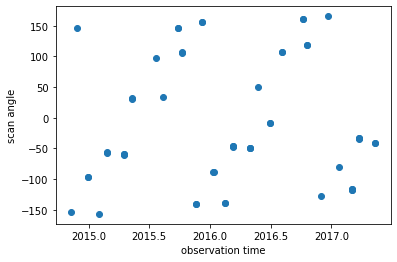

In [68]:
ax=plt.gca()
ax.scatter(ts,phis)
ax.set_xlabel(r'observation time')
ax.set_ylabel(r'scan angle')
plt.savefig('docs/plots/scanningLaw.png')
plt.show()

In [69]:
params=astromet.params()

params.ra=ra
params.dec=dec
params.drac=0
params.ddec=0
params.pmrac=8
params.pmdec=-2
params.pllx=5

params.period=2
params.a=2 
params.e=0.8
params.q=0.5
params.l=0.1

params.vphi=4.5
params.vtheta=1.5
params.vomega=5.6

params.tperi=2016

racs,decs=astromet.track(ts,params)

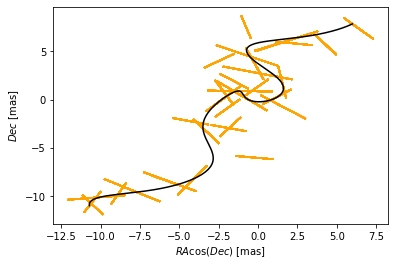

In [104]:
mag=18
al_error=astromet.sigma_ast(mag) # about 1.1 mas at this magnitude
errs=al_error*np.random.randn(phis.size)

radphis=np.deg2rad(phis)

obsracs=racs+errs*np.sin(radphis)
obsdecs=decs+errs*np.cos(radphis)

plotts=np.linspace(np.min(ts),np.max(ts),1000)
plotracs,plotdecs=astromet.track(plotts,params)

ax=plt.gca()
for i in range(ts.size):
    ax.plot([obsracs-al_error*np.sin(radphis),obsracs+al_error*np.sin(radphis)],
            [obsdecs-al_error*np.cos(radphis),obsdecs+al_error*np.cos(radphis)],c='orange')
ax.plot(plotracs,plotdecs,c='k')
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBodyScans')
plt.show()

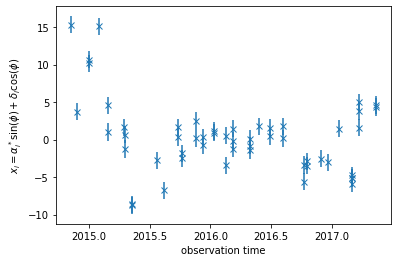

In [103]:
xs=obsracs*np.sin(radphis) + obsdecs*np.cos(radphis)

ax=plt.gca()
ax.errorbar(ts,xs,yerr=al_error,fmt='x')
ax.set_xlabel(r'observation time')
ax.set_ylabel(r'$x_i = \alpha^*_i\ \sin(\phi) + \delta_i\ \cos(\phi)$')
plt.savefig('docs/plots/scanXs.png')
plt.show()

In [114]:
bresults=astromet.gaia_fit(ts,xs,phis,al_error,ra,dec)
print(bresults)